In [1]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv("/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/Training_set.csv")

In [3]:
df

,filename,label
0,Image_1.jpg,sitting
1,Image_2.jpg,using_laptop
2,Image_3.jpg,hugging
3,Image_4.jpg,sleeping
4,Image_5.jpg,using_laptop
...,...,...
12595,Image_12596.jpg,sitting
12596,Image_12597.jpg,clapping
12597,Image_12598.jpg,sitting
12598,Image_12599.jpg,dancing


In [4]:
label = np.array(df['label'])

In [5]:
val, count = np.unique(label, return_counts=True)

In [6]:
val,count

(array(['calling', 'clapping', 'cycling', 'dancing', 'drinking', 'eating',
        'fighting', 'hugging', 'laughing', 'listening_to_music', 'running',
        'sitting', 'sleeping', 'texting', 'using_laptop'], dtype=object),
 array([840, 840, 840, 840, 840, 840, 840, 840, 840, 840, 840, 840, 840,
        840, 840]))

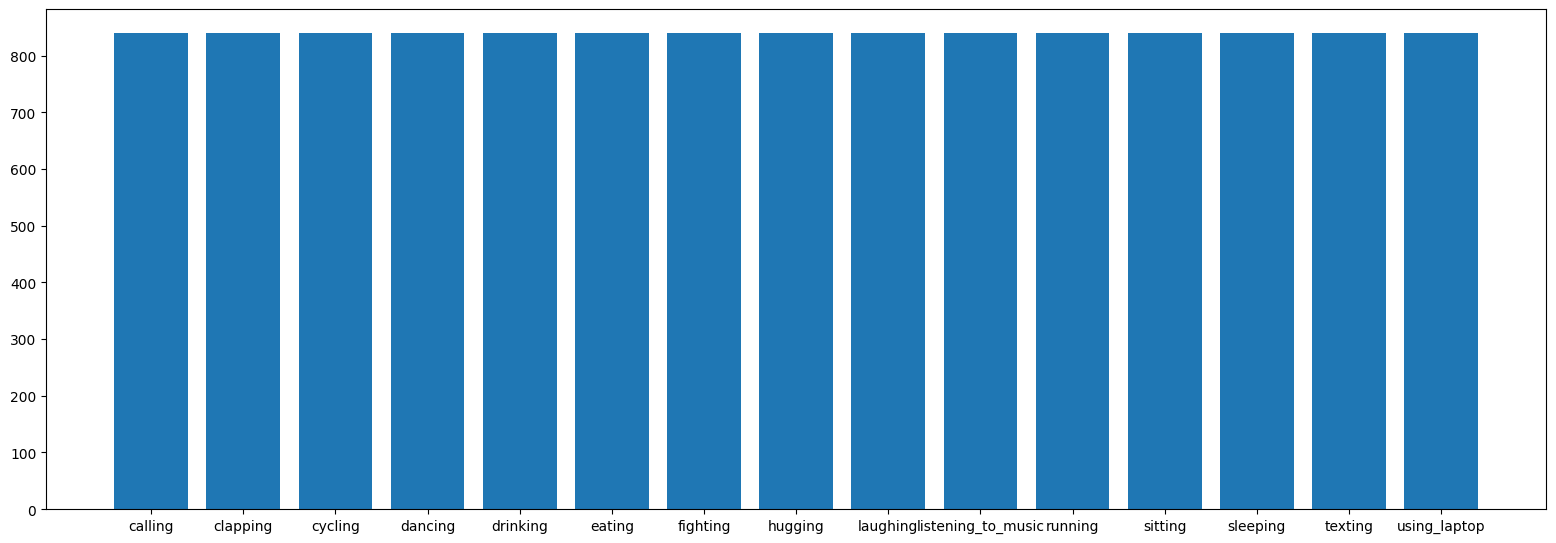

In [7]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_axes([0,0,1,1])
act = val
values = np.array(count)
ax.bar(act, values)
plt.show()

In [8]:
images = []
label = []

In [9]:
activity = list(val)
len(activity)

15

In [10]:
import cv2

In [11]:
def rotate_image(image, angle):
  center = tuple(np.array(image.shape[1::-1])/2)
  rot_mat = cv2.getRotationMatrix2D(center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_CUBIC)
  return result

In [12]:
for i in range(len(df['filename'])):
        file = "/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/train/"+df['filename'][i]
        im = cv2.imread(file)
        im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
        im = cv2.resize(im,(48,48))
        im = im/255
        print(file)
        images.append(im)
        label.append(activity.index(df['label'][i]))
        for j in range(4):
            im = cv2.flip(im,1)
            if j%2==0:
                im = rotate_image(im,4)
            else:
                im = rotate_image(im,-3)
            images.append(im)
            label.append(activity.index(df['label'][i]))
            

/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/train/Image_1.jpg
/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/train/Image_2.jpg
/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/train/Image_3.jpg
/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/train/Image_4.jpg
/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/train/Image_5.jpg
/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/train/Image_6.jpg
/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/train/Image_7.jpg
/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/train/Image_8.jpg
/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/train/Image_9.jpg
/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/train/Image_10.jpg
/kaggle/input/human-action-recognition-har-dataset/Human Ac

In [13]:
images = np.array(images)
label = np.array(label)

In [14]:
from keras.utils import to_categorical
label = to_categorical(label,15)
label.shape

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


(63000, 15)

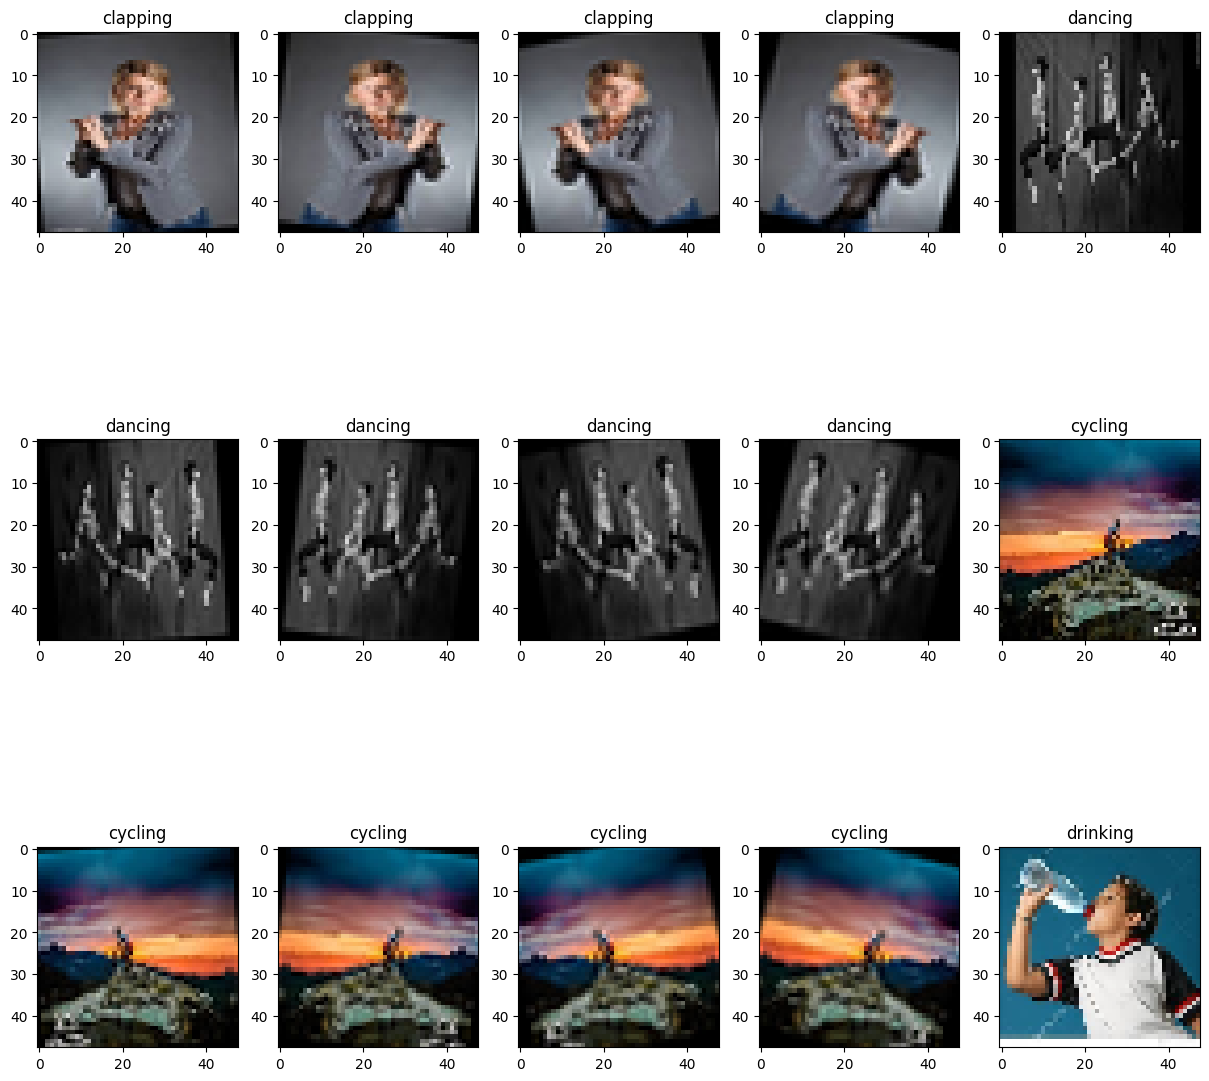

In [15]:
plt.figure(figsize=(15,15))
for i in range(1,16):
    plt.subplot(3,5,i)
    plt.imshow(images[i+40])
    plt.title(activity[label[i+40].argmax()])

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
x_train,x_test,y_train,y_test = train_test_split(images,label,test_size=0.2, stratify=label, shuffle=True)
x_train.shape,x_test.shape

((50400, 48, 48, 3), (12600, 48, 48, 3))

In [18]:
from tensorflow import keras
from keras.layers import Dropout,Flatten,Dense,MaxPooling2D,Conv2D
from keras.models import Sequential
from keras.optimizers import Adam

In [19]:
model = Sequential()
model.add(Conv2D(64, 3, activation='relu', input_shape=(48,48,3)))
model.add(MaxPooling2D())
model.add(Dropout(0.4))

model.add(Conv2D(128, 3, activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.4))

model.add(Conv2D(256, 3, activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(15, activation='softmax'))

In [20]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 23, 23, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 10, 10, 128)       0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 10, 10, 128)       0

In [21]:
from keras.callbacks import ModelCheckpoint,EarlyStopping

In [22]:
file_s = "Human_Activity_Recognition.h5"
checkpoint = ModelCheckpoint(file_s, monitor="val_loss", verbose=1, save_best_only=True, save_weights_only=False, mode="auto", freq="epoch")
Early_stop = EarlyStopping(patience=25, monitor="val_loss", restore_best_weights=True)
callback_list = [checkpoint,Early_stop]

In [23]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=64, epochs=250, callbacks=[callback_list])

Epoch 1/250


2023-12-21 16:46:24.811591: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


788/788 [==============================] - ETA: 0s - loss: 2.4451 - accuracy: 0.1917
Epoch 1: val_loss improved from inf to 2.22572, saving model to Human_Activity_Recognition.h5
788/788 [==============================] - 19s 13ms/step - loss: 2.4451 - accuracy: 0.1917 - val_loss: 2.2257 - val_accuracy: 0.2870
Epoch 2/250
  7/788 [..............................] - ETA: 7s - loss: 2.4325 - accuracy: 0.2232

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


786/788 [============================>.] - ETA: 0s - loss: 2.1285 - accuracy: 0.3063
Epoch 2: val_loss improved from 2.22572 to 2.21603, saving model to Human_Activity_Recognition.h5
788/788 [==============================] - 8s 11ms/step - loss: 2.2289 - accuracy: 0.3063 - val_loss: 2.2160 - val_accuracy: 0.2881
Epoch 3/250
783/788 [============================>.] - ETA: 0s - loss: 2.0857 - accuracy: 0.3175
Epoch 3: val_loss improved from 2.21603 to 1.88545, saving model to Human_Activity_Recognition.h5
788/788 [==============================] - 8s 11ms/step - loss: 2.1035 - accuracy: 0.3174 - val_loss: 1.8854 - val_accuracy: 0.3952
Epoch 4/250
783/788 [============================>.] - ETA: 0s - loss: 1.8902 - accuracy: 0.3847
Epoch 4: val_loss improved from 1.88545 to 1.79375, saving model to Human_Activity_Recognition.h5
788/788 [==============================] - 8s 10ms/step - loss: 1.9150 - accuracy: 0.3848 - val_loss: 1.7938 - val_accuracy: 0.4251
Epoch 5/250
784/788 [==========

In [24]:
model.evaluate(x_test, y_test)

394/394 [==============================] - 1s 4ms/step - loss: 2.7883 - accuracy: 0.0683


[2.788297414779663, 0.06825397163629532]

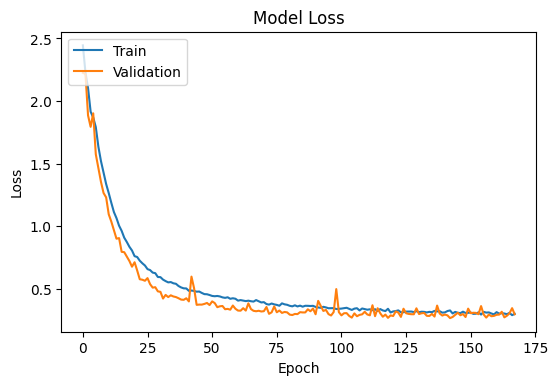

In [25]:
plt.figure(figsize=(5,3))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"], loc="upper left")
plt.subplots_adjust(left=0, bottom=0, top=1, right=0.95, wspace=0.35, hspace=0.25)

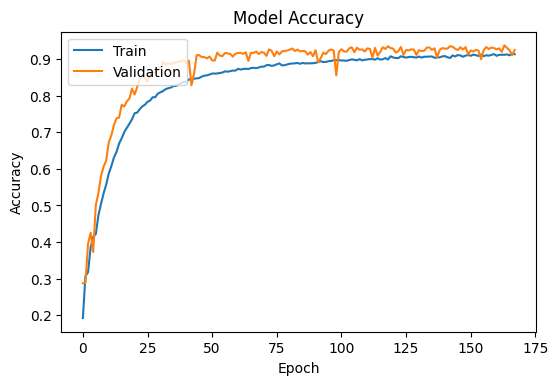

In [26]:
plt.figure(figsize=(5,3))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"], loc="upper left")
plt.subplots_adjust(left=0, bottom=0, top=1, right=0.95, wspace=0.35, hspace=0.25)

In [27]:
pred = model.predict(x_test)

394/394 [==============================] - 1s 2ms/step


In [28]:
pred_l = []
y_l = []

In [29]:
for p in pred:
    pred_l.append(p.argmax())
for y in y_test:
    y_l.append(y.argmax())

pred_l = np.array(pred_l)

In [30]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [31]:
result = confusion_matrix(y_l, pred_l)
report = classification_report(y_l, pred_l)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.00      0.00       840
           1       1.00      0.00      0.00       840
           2       1.00      0.00      0.00       840
           3       1.00      0.00      0.01       840
           4       1.00      0.00      0.00       840
           5       0.07      1.00      0.13       840
           6       1.00      0.00      0.00       840
           7       1.00      0.00      0.00       840
           8       1.00      0.00      0.00       840
           9       1.00      0.00      0.00       840
          10       0.00      0.00      0.00       840
          11       1.00      0.00      0.00       840
          12       1.00      0.00      0.00       840
          13       1.00      0.00      0.01       840
          14       0.50      0.00      0.00       840

    accuracy                           0.07     12600
   macro avg       0.84      0.07      0.01     12600
weighted avg       0.84   

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Axes: >

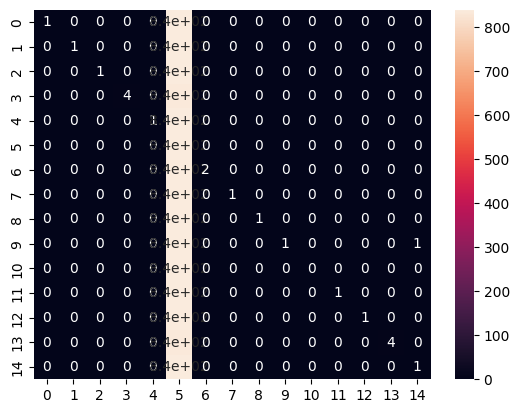

In [32]:
import seaborn as sns
sns.heatmap(result,annot=True)

In [33]:
t = os.listdir("/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/test")
len(t)

5410

2/2 [==============================] - 0s 49ms/step


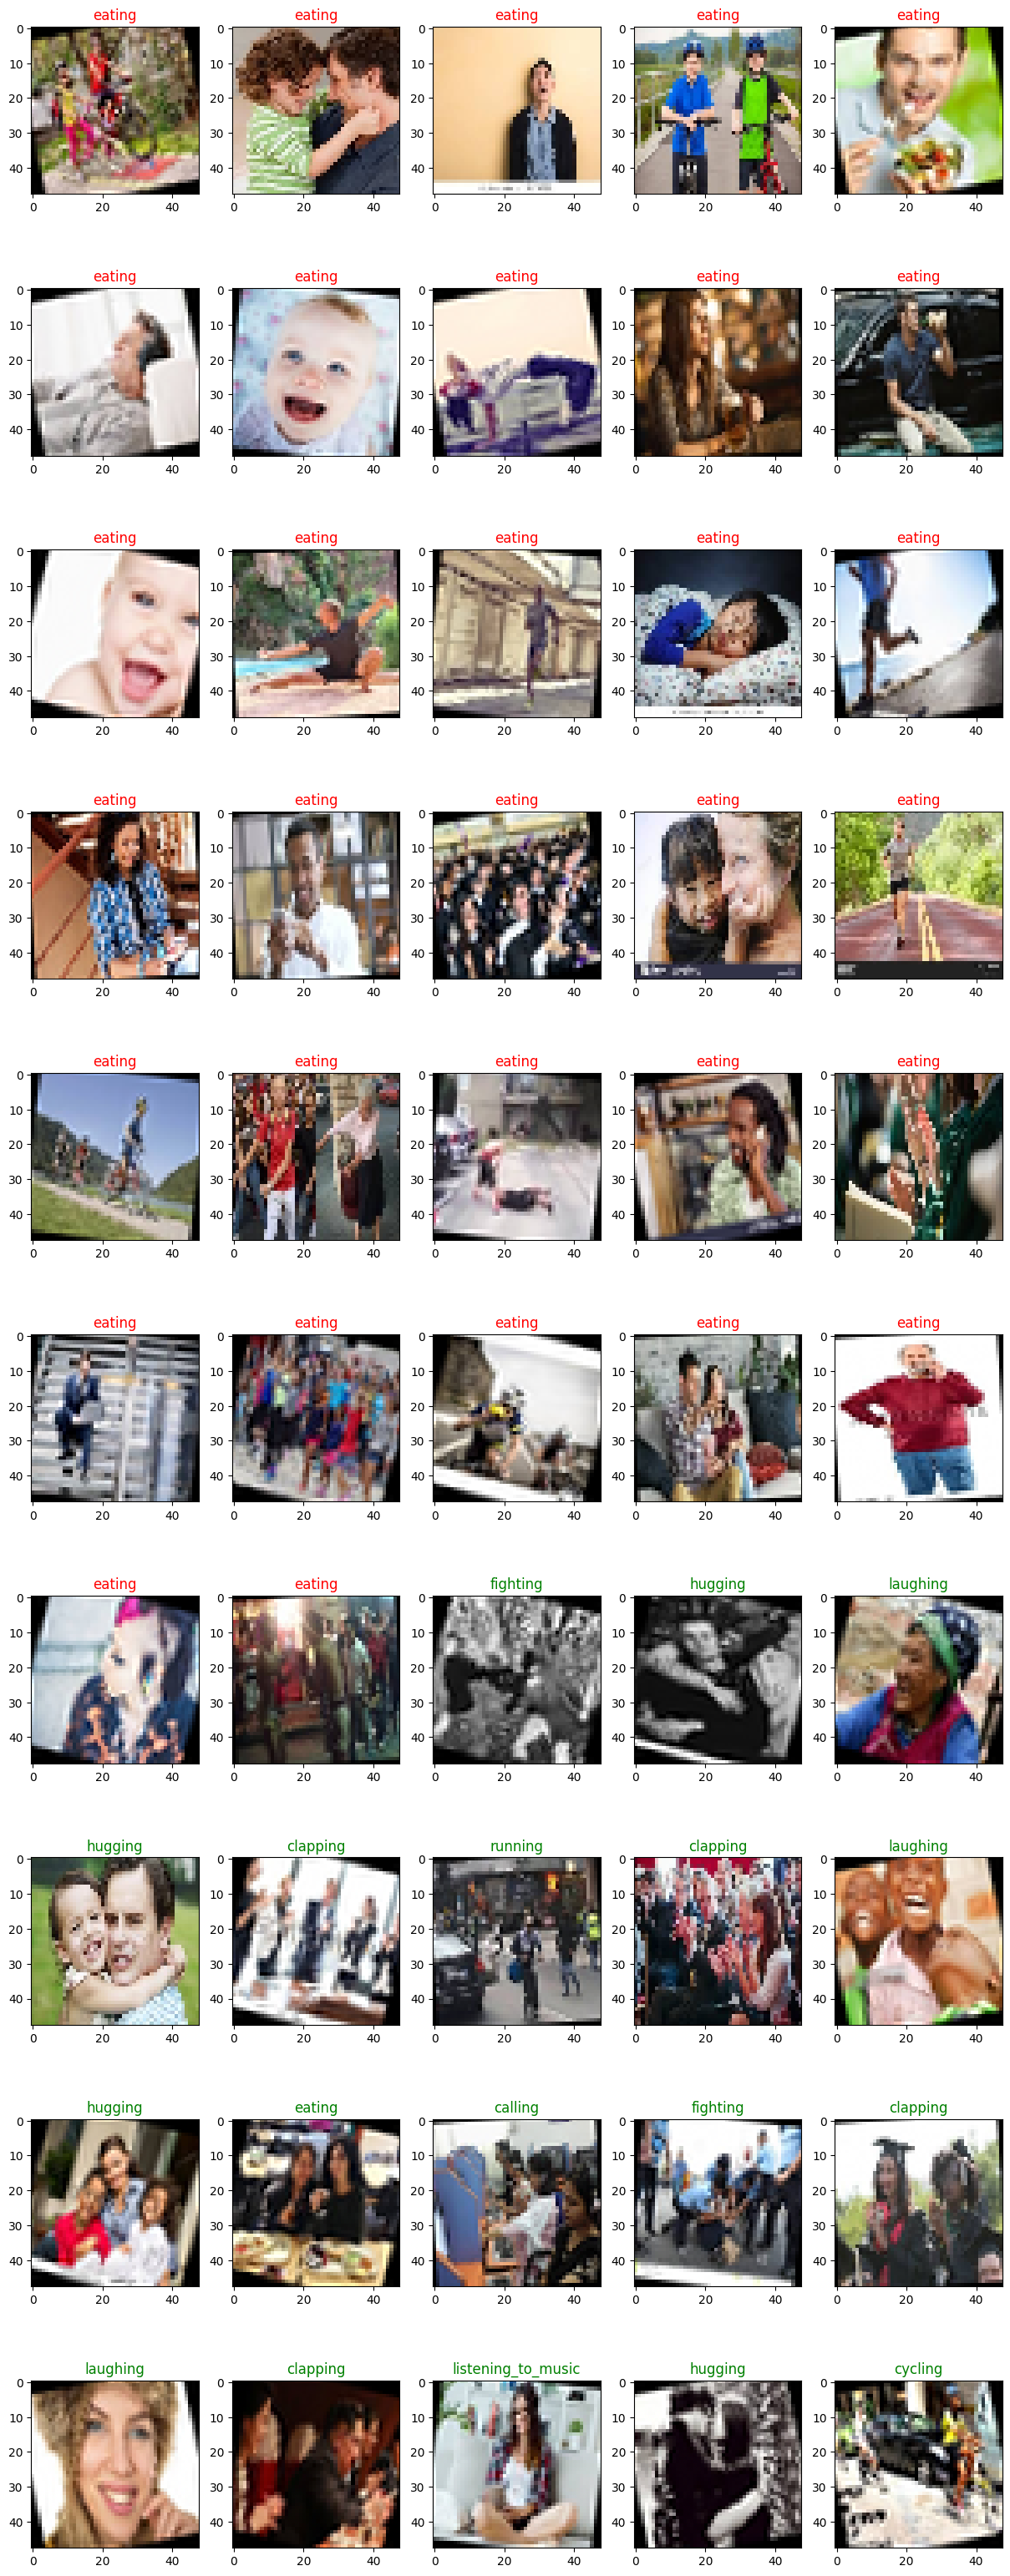

In [34]:
import random
x = []
y = []
for i in range(0,50):
    n = random.randint(0,10080)
    x.append(x_test[n])
    y.append(y_test[n])
x = np.array(x)
e = model.predict(x)

plt.figure(figsize=(15,40))

for i in range(1,51):
    plt.subplot(10,5,i)
    plt.imshow(x[i-1])
    plt.title(activity[e[i-1].argmax()], color='green' if e[i-1].argmax()==y[i-1].argmax() else 'red')

2/2 [==============================] - 0s 3ms/step


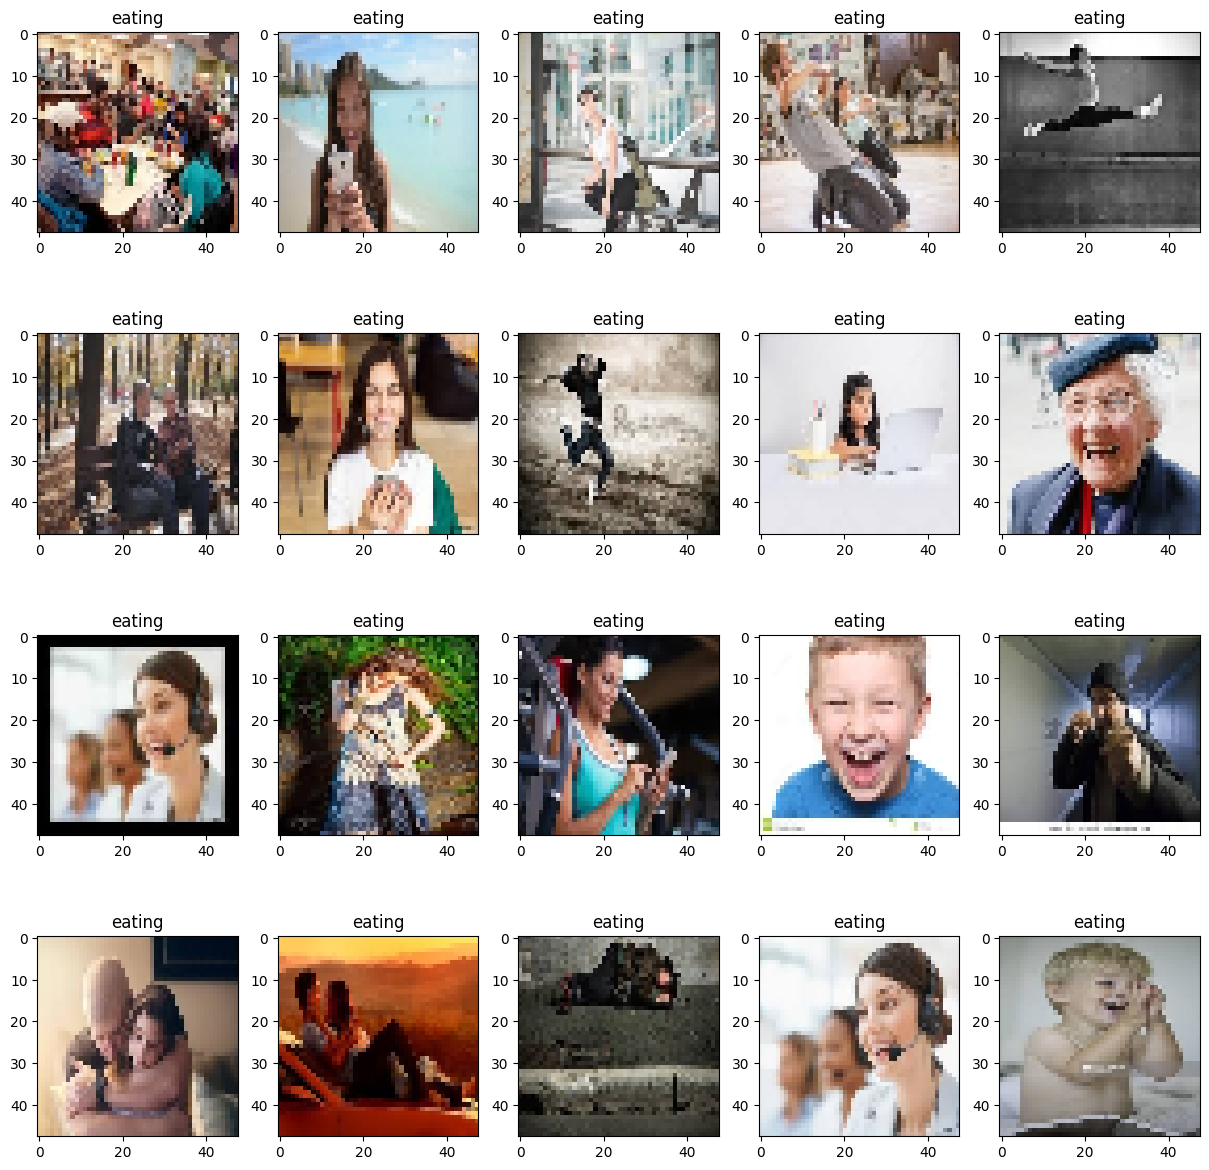

In [35]:
import random
x = []
for i in range(0,50):
    n = random.randint(0,5410)
    img_f = "/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/test/"+t[n]
    img = cv2.imread(img_f)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(48,48))
    img = img/255
    x.append(img)
x = np.array(x)
e = model.predict(x)

plt.figure(figsize=(15,15))

for i in range(1,21):
    plt.subplot(4,5,i)
    plt.imshow(x[i-1])
    plt.title(activity[e[i-1].argmax()])